In [2]:
from msclap import CLAP
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd
import os

In [53]:
specialities = pd.read_csv('specialities.csv')
display(specialities)

speciality_subtypes= {
    'bell':['bell'],
	'bird':['wild_animals'],
	'car':['engine', 'vehicle'],
	'car_cabin': ['engine', 'vehicle'],
	'dog':['domestic animals/pets'],
	'door':['generic impact sounds', 'domestic sounds/home sounds'],
	'eating':['surface contact', 'generic impact sounds', 'food packaging', 'eating/digestive'],
	'fan':['fan/air conditioning'],
	'kids_screaming':['other', 'instrumental music'],
	'kitchen_noises':['domestic sounds/home sounds', 'generic impact sounds'],
	'low_rev_engines':['engine'],
	'water':['liquid/water'],
	'wind':['weather']
}

,speciality,meta_csv,audios
0,bell,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
1,bird,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
2,car,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
3,car,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
4,car_cabin,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
5,dog,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
6,door,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
7,eating,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
8,fan,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
9,kids_screaming,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...


In [56]:
metadf_dict={}
speciality_dict={}
for row in specialities.itertuples(index=False):
    #print(f"working on {row.speciality}")
    csv = pd.read_csv(row.meta_csv)
    #print(csv['sub_type'].value_counts())
    csv = csv[csv['sub_type'].isin(speciality_subtypes[row.speciality])]
    #print(csv['sub_type'].value_counts())
    
    metadf_dict[row.speciality] = csv
    
    audio_paths = metadf_dict[row.speciality]['filepath']
    speciality_dict[row.speciality] = list(audio_paths)

In [50]:
prompt_mapping = {'water':'water',
                  'eating':'eating',
                  'car_cabin':'inside of car',
                  'bell':'bell',
                  'door':'door',
                  'wind':'wind',
                  'bird':'bird',
                  'kitchen_noises':'kitchen appliances cooking',
                  'kids_screaming':'kids screaming',
                  'car':'car',
                  'dog':'dog',
                  'low_rev_engines':'engine',
                  'fan':'fan'}

In [57]:
records = []
for specialty, file_paths in speciality_dict.items():
    specialty_prompt = prompt_mapping[specialty]
    for file_path in file_paths:
        records.append({'specialty': specialty_prompt, 'file_path': file_path})

# Create a DataFrame
df = pd.DataFrame(records)
print(df['specialty'].value_counts())

specialty
eating                    2810
water                     1945
bell                      1582
door                      1582
car cabin                 1577
wind                       865
kitchen noises             798
car                        650
low revolution engines     493
kids screaming             466
dog                        462
fan                        164
Name: count, dtype: int64


In [58]:
classes = df['specialty'].unique()

class_id_map = {name: i for i, name in enumerate(classes, 0)}
print(class_id_map)

prompt = 'this is the sound of '
y = [prompt + x for x in classes]


{'bell': 0, 'car': 1, 'car cabin': 2, 'dog': 3, 'door': 4, 'eating': 5, 'fan': 6, 'kids screaming': 7, 'kitchen noises': 8, 'low revolution engines': 9, 'water': 10, 'wind': 11}


In [60]:
# Load and initialize CLAP
clap_model = CLAP(version = '2023', use_cuda=True)

# Computing text embeddings
text_embeddings = clap_model.get_text_embeddings(y)

In [61]:
# Computing audio embeddings
y_preds, y_labels = [], []
print(os.getcwd())

for i in tqdm(range(len(df ))):
    label, path = df.iloc[i]
    idx = class_id_map[label]
    #print(idx)
    one_hot_target = torch.nn.functional.one_hot(torch.tensor([idx]), num_classes=len(classes)+1)

    audio_embeddings = clap_model.get_audio_embeddings([path], resample=True)
    similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)

    y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()

    y_preds.append(y_pred)
    y_labels.append(one_hot_target.detach().cpu().numpy())


/mounts/ud-data/jtaylor/a5f2c23d-7fb6-41a6-ac0c-3a2ffc02b992/data/acoustic_scene_classification/CLAP-main/examples


  0%|          | 5/13394 [00:00<04:43, 47.24it/s]

100%|██████████| 13394/13394 [05:17<00:00, 42.24it/s]


In [62]:
y_lab, y_pred = np.concatenate(y_labels, axis=0), np.concatenate(y_preds, axis=0)
y_label_val = np.argmax(y_lab, axis=1)
y_pred_val = np.argmax(y_pred, axis=1)
acc = accuracy_score(np.argmax(y_lab, axis=1), np.argmax(y_pred, axis=1))
print('Speciality Accuracy {}'.format(acc))

Speciality Accuracy 0.6873973420934747


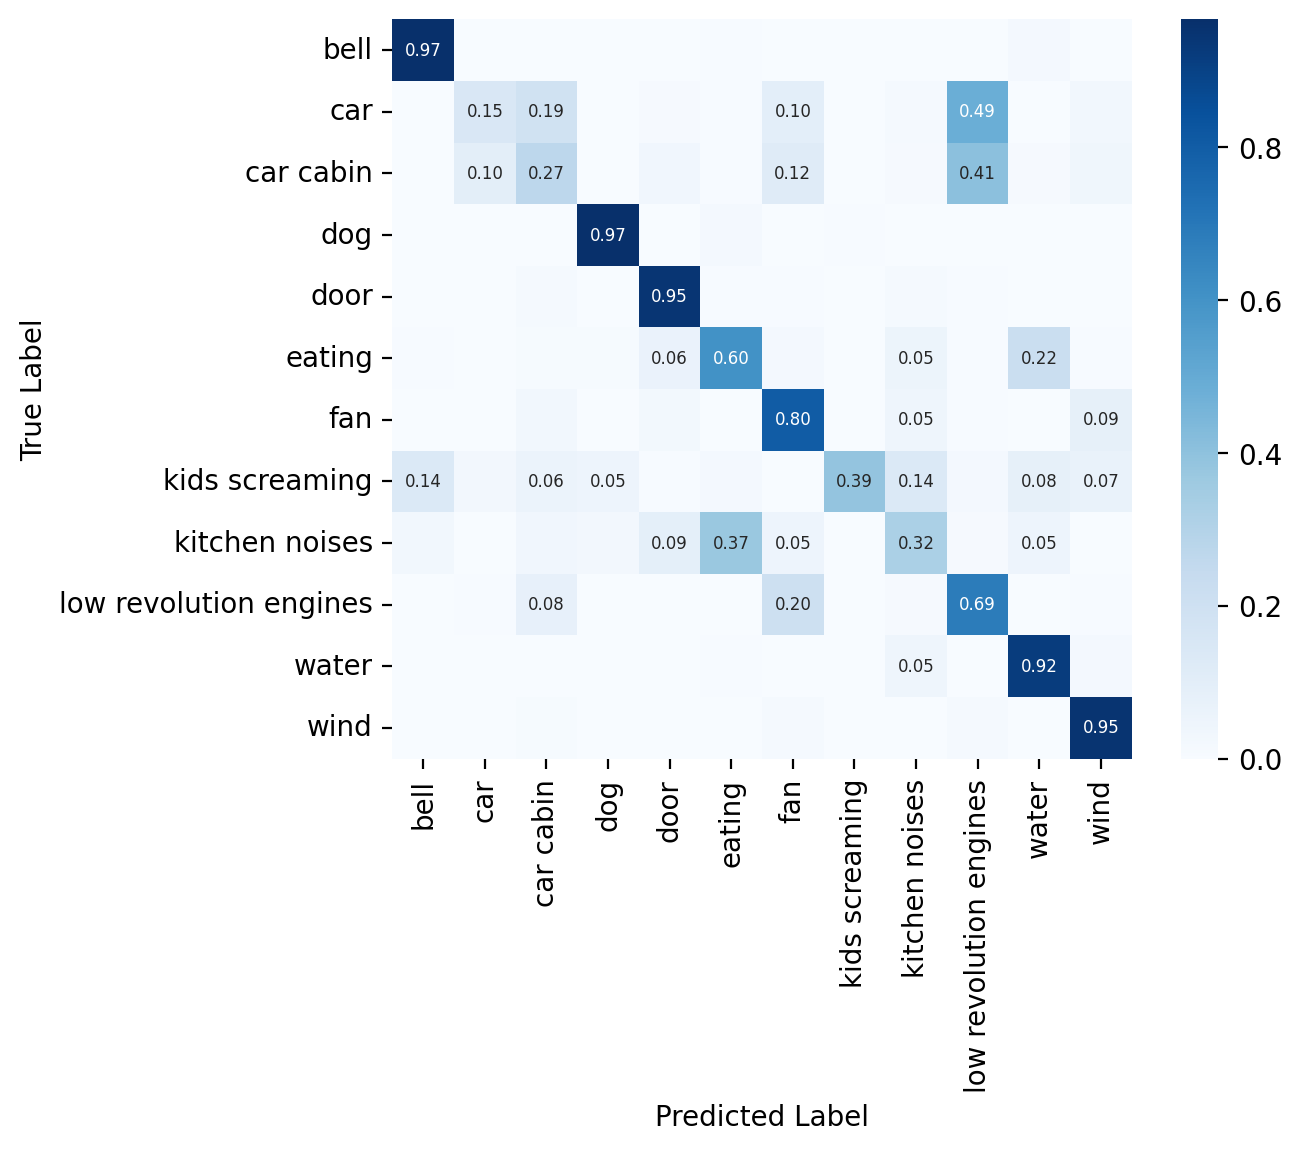

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# get confusion matrix
conf_matrix = confusion_matrix(y_label_val,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
mean_recall = np.mean(recall_by_class)

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

plt.figure(dpi=200)

annot_kws = {'size': 6}
ax = sns.heatmap(percentages, xticklabels=classes, yticklabels=classes, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True Label')

#plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()